## **Linear Regression**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import warnings
import plotly.express as px

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('./NFLX.csv')
df.head()

In [ ]:
viz = df.copy()

In [ ]:
df.isnull().sum()

In [ ]:
# drop duplicates
df = df.drop_duplicates()

In [ ]:
df.info()

In [ ]:
# Calculate the index for the 80-20 split
split_index = int(len(df) * 0.8)

# Split the dataset into training and testing sets using the calculated index
train = df[:split_index]
test = df[split_index:]

# Display the shapes of the resulting DataFrames to verify the split
print("Training set shape :", train.shape)
print("Testing set shape :", test.shape)

In [ ]:
test_pred = test.copy()

In [ ]:
x_train = train[['Open', 'High', 'Low', 'Volume']].values
x_test = test[['Open', 'High', 'Low', 'Volume']].values

In [ ]:
y_train = train['Close'].values
y_test = test['Close'].values

In [ ]:
model_lnr = LinearRegression()
model_lnr.fit(x_train, y_train);
y_pred = model_lnr.predict(x_test)

In [ ]:
print("MSE",round(mean_squared_error(y_test,y_pred), 3))
print("RMSE",round(np.sqrt(mean_squared_error(y_test,y_pred)), 3))
print("MAE",round(mean_absolute_error(y_test,y_pred), 3))
print("MAPE",round(mean_absolute_percentage_error(y_test,y_pred), 3))
print("R2 Score : ", round(r2_score(y_test,y_pred), 3))

In [ ]:
def style():
    plt.figure(facecolor='black', figsize=(15,10))
    ax = plt.axes()

    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to white
    ax.tick_params(axis='y', colors='white')    #setting up Y-axis tick color to white

    ax.spines['left'].set_color('white')        #setting up Y-axis spine color to white
    #ax.spines['right'].set_color('white')
    #ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')      #setting up X-axis spine color to white

    ax.set_facecolor("black")

In [ ]:
viz['Date']=pd.to_datetime(viz['Date'],format='%Y-%m-%d')

In [ ]:
data = pd.DataFrame(viz[['Date','Close']])
data=data.reset_index()
data=data.drop('index',axis=1)
# drop duplicates
data.set_index('Date', inplace=True)
data = data.asfreq('D')
#data = data.drop_duplicates()
data

In [ ]:
test_pred = test.copy()
test_pred['Close_Prediction'] = y_pred
test_pred

In [ ]:
# plot prdictions vs actual values on test_pred using plotly express
fig = px.line(test_pred, x='Date', y=['Close', 'Close_Prediction'], title='Close Price vs Close Price Prediction')
# bigger size
fig.update_layout(width=900, height=600)
fig.show();

## **LSTM**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import warnings
import plotly.express as px

In [2]:
df = pd.read_csv('./NFLX.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
dataset = pd.DataFrame(df.reset_index()["Close"])
data = dataset.values
data = data.astype('float32')

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)


In [6]:
train_size = int(len(data)*0.8)
test_size = len(data)-train_size 
train, test = data[0:train_size,:], data[train_size:len(data),:] 
print(len(train), len(test))

807 202


In [7]:
# function to take 
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# train and test set
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

# reshape the X and y data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(805, 1, 1) (805,) (200, 1, 1) (200,)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)


In [9]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=4, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 4).to(device)  # Hidden state
        c_0 = torch.zeros(1, x.size(0), 4).to(device)  # Cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Take the last output of the sequence
        return out


In [13]:
model = LSTMModel().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(trainX)
    loss = criterion(outputs, trainY.unsqueeze(1))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [11]:
# Predictions
model.eval()
trainPredict = model(trainX).detach().cpu().numpy()
testPredict = model(testX).detach().cpu().numpy()

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.cpu().numpy().reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.cpu().numpy().reshape(-1, 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 48.45 RMSE
Test Score: 110.14 RMSE


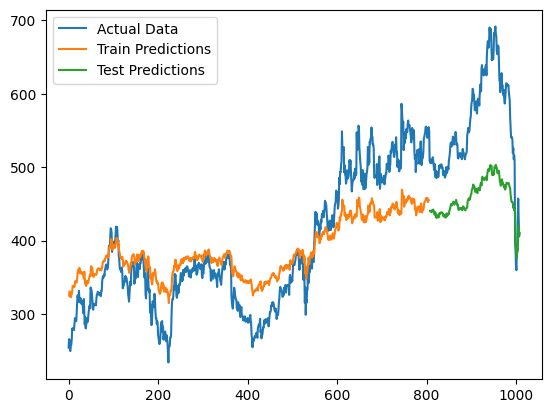

In [12]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(data) - 1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(data), label="Actual Data")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.legend()
plt.show()


## **AIRIMA**